<a href="https://colab.research.google.com/github/NINGTANG1124/UPF-HFI/blob/main/notebooks/final_model_chinese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# connect to googledrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 合并 HFI 到建模数据表

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 120)

# 读取
survey_df = pd.read_excel( "/content/drive/MyDrive/UPF-HFI/Model/outcome/survey_with_HFI.xlsx")
df_upf    = pd.read_excel("/content/drive/MyDrive/UPF-HFI/Model/outcome/weighted_upf_percent.xlsx")

In [3]:
# ==== 2. 先检查 ====
issues = []

# 检查关键列
for col in ["UserID_clean", "HFI_binary", "HFI_raw_score"]:
    if col not in survey_df.columns:
        issues.append(f"survey 缺少 {col}")

for col in ["UserID_clean", "weighted_upf_percent"]:
    if col not in df_upf.columns:
        issues.append(f"upf 缺少 {col}")

# 检查 ID 是否有缺失/重复
for name, df in [("survey", survey_df), ("upf", df_upf)]:
    n_na = df["UserID_clean"].isna().sum()
    n_dup = df["UserID_clean"].duplicated().sum()
    if n_na:  issues.append(f"{name} 的 UserID_clean 有 {n_na} 个缺失")
    if n_dup: issues.append(f"{name} 的 UserID_clean 有 {n_dup} 个重复")

# 检查 upf_percent 是否数值
bad_upf = pd.to_numeric(df_upf["weighted_upf_percent"], errors="coerce").isna().sum()
if bad_upf:
    issues.append(f"weighted_upf_percent 有 {bad_upf} 个非数值/缺失")

# 打印检查结果
if issues:
    print("检查发现以下问题：")
    for i, msg in enumerate(issues, 1):
        print(f"{i}. {msg}")
else:
    print("没有发现问题，可以直接处理")


没有发现问题，可以直接处理


In [4]:
# ==== 检查关键变量缺失情况 ====
check_cols = ["HFI_binary", "weighted_upf_percent"]
missing_info = {}

for col in check_cols:
    if col not in survey_df.columns and col not in df_upf.columns:
        print(f"数据中找不到列: {col}")
        continue

    if col in survey_df.columns:
        n_miss = survey_df[col].isna().sum()
        missing_info[col] = n_miss
        print(f"{col} 在 survey_df 中缺失 {n_miss} 行")

    if col in df_upf.columns:
        n_miss = df_upf[col].isna().sum()
        missing_info[col] = n_miss
        print(f"{col} 在 upf_df 中缺失 {n_miss} 行")

# ==== 判断是否需要处理 ====
if all(v == 0 for v in missing_info.values()):
    print("两列都没有缺失，可以直接进入合并/建模")
else:
    print("存在缺失，需要处理后再合并")


HFI_binary 在 survey_df 中缺失 18 行
weighted_upf_percent 在 upf_df 中缺失 0 行
存在缺失，需要处理后再合并


In [5]:
# 1. 合并 survey 和 upf
df_model = pd.merge(survey_df, df_upf, on="UserID_clean", how="inner")

# 2. 删掉 HFI_binary 缺失的
df_model = df_model.dropna(subset=["HFI_binary"])

print("合并后样本量：", len(df_model))


合并后样本量： 308


In [6]:
# 导出合并后的数据
df_model.to_excel("/content/drive/MyDrive/UPF-HFI/Model/outcome/merged_model.xlsx", index=False)

print("已导出到 /content/drive/MyDrive/UPF-HFI/Model/outcome/merged_model.xlsx")


已导出到 /content/drive/MyDrive/UPF-HFI/Model/outcome/merged_model.xlsx


# 0. 准备：工具函数

In [7]:
# =============================================
# ============  Imports & Settings  ============
# =============================================
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)

# ------------------------------------------------
# ----- 正态分位工具（SciPy优先，内置做后备） -----
# ------------------------------------------------
try:
    from scipy.stats import norm as _norm
    def _zcrit(alpha=0.05):   # 双侧 alpha -> z*
        return _norm.ppf(1 - alpha/2)
    def _cdf(x):
        return _norm.cdf(x)
except Exception:
    from statistics import NormalDist
    _nd = NormalDist()
    def _zcrit(alpha=0.05):
        return _nd.inv_cdf(1 - alpha/2)
    def _cdf(x):
        return _nd.cdf(x)

# --------------------------------
# ----- OLS 拟合（稳健方差） -----
# --------------------------------
def fit_ols(formula, data, cov_type="HC3"):
    """
    OLS 拟合 + 稳健标准误（默认 HC3）
    返回：robust 结果对象
    """
    model = smf.ols(formula, data=data).fit()
    if cov_type:
        model = model.get_robustcov_results(cov_type=cov_type)
    return model

# ----------------------------------------------------------
# ----- 统一结果取值（兼容 ndarray / pandas.Series） -----
# ----------------------------------------------------------
def _names_params_bse_p(res):
    """
    统一把 params/bse/pvalues 取成 Series，并带上模型列名。
    无论 statsmodels 返回 ndarray 还是 Series 都能兼容。
    """
    names   = list(res.model.exog_names)
    params  = pd.Series(np.asarray(res.params).ravel(),  index=names)
    bse     = pd.Series(np.asarray(res.bse).ravel(),     index=names)
    pvalues = pd.Series(np.asarray(res.pvalues).ravel(), index=names)
    return names, params, bse, pvalues

def get_term(result, term, default=np.nan):
    """安全获取某个项的系数（不存在则给默认值）。"""
    _, params, _, _ = _names_params_bse_p(result)
    return params.get(term, default)

# ------------------------------------------------------------
# ----- 置信区间 / 线性组合（边际效应）/ 交互整体检验 -----
# ------------------------------------------------------------
def coef_ci(result, term, alpha=0.05):
    """
    取指定项的点估计、95%CI 和 p 值；若项不存在返回 None
    """
    names, params, bse, pvalues = _names_params_bse_p(result)
    if term not in params.index:
        return None
    est = params[term]
    se  = bse[term]
    z   = _zcrit(alpha)
    ci  = (est - z*se, est + z*se)
    return est, ci, pvalues[term]

def linear_combo(result, combo):
    """
    线性组合估计（用于交互项下的 HFI 边际效应等）
    combo 例子：
      {'HFI_binary':1,
       "HFI_binary:C(ethn_participant, Treatment(reference='White'))[T.Asian]":1}
    返回：(点估计, 95%CI, p 值)
    """
    names, params, _, _ = _names_params_bse_p(result)
    cov = np.asarray(result.cov_params())
    w = np.zeros(len(names))
    for k, v in combo.items():
        if k in names:
            w[names.index(k)] = v
    est = float(np.dot(w, params.values))
    var = float(np.dot(w, np.dot(cov, w)))
    se  = np.sqrt(var)
    if se > 0:
        zval = est / se
        ci   = (est - _zcrit(0.05)*se, est + _zcrit(0.05)*se)
        p    = 2 * (1 - _cdf(abs(zval)))
    else:
        ci, p = (np.nan, np.nan), np.nan
    return est, ci, p

def joint_test_interaction(result, prefix):
    """
    交互整体检验：检验所有以 prefix 开头的系数为 0
    例如 prefix = "HFI_binary:C(ethn_participant, Treatment(reference='White'))"
    """
    names, params, _, _ = _names_params_bse_p(result)
    terms = [nm for nm in names if nm.startswith(prefix)]
    if not terms:
        return np.nan
    R = np.zeros((len(terms), len(names)))
    for i, t in enumerate(terms):
        R[i, names.index(t)] = 1.0
    ft = result.f_test(R)
    return float(np.asarray(ft.pvalue))

# -------------------------
# ----- 绘图（coefplot） -----
# -------------------------
def coefplot(ax, labels, est, lo, hi, title, xlabel="Coefficient (pp)"):
    """
    系数图（点 + 95%CI）
    labels: y 轴标签列表
    est/lo/hi: 对应点估计与置信区间上下界的等长列表
    """
    y = np.arange(len(labels))
    ax.errorbar(est, y, xerr=[est-lo, hi-est], fmt='o', capsize=4)
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.axvline(0, linestyle='--', linewidth=1)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.invert_yaxis()


# 1. 族裔合并

In [8]:
assert "ethn_participant" in df_model.columns, "未找到 ethn_participant 列（应为1–9编码）。"

# 备份原始九类编码
df_model = df_model.copy()
df_model.rename(columns={"ethn_participant": "ethn_participant_raw"}, inplace=True)

# 强制转换为整数编码，兼容缺失
codes = pd.to_numeric(df_model["ethn_participant_raw"], errors="coerce").astype("Int64")

# 映射到三大类
code_to_ethn3 = {
    1: "White", 2: "White",
    3: "Asian", 4: "Asian", 5: "Asian", 6: "Asian",
    7: "All other ethnicities", 8: "All other ethnicities", 9: "All other ethnicities"
}
df_model["ethn_participant"] = codes.map(code_to_ethn3)

# 设定为分类变量并固定顺序（参考组=White）
df_model["ethn_participant"] = pd.Categorical(
    df_model["ethn_participant"],
    categories=["White", "Asian", "All other ethnicities"],
    ordered=False
)

# 健诊：展示原始九类分布与三类分布
print("原始九类（1–9）计数：")
print(codes.value_counts(dropna=False).sort_index())
print("\n合并后三类计数（含缺失）：")
print(df_model["ethn_participant"].value_counts(dropna=False))

# 若存在异常编码（非1–9），提示但不报错
invalid = codes[~codes.isin(list(range(1,10))) & codes.notna()].unique()
if len(invalid) > 0:
    print(f"\n[提示] 发现非常规族裔编码：{list(invalid)}；已在合并后记为缺失。")

原始九类（1–9）计数：
ethn_participant_raw
1    156
2     13
3     76
4     10
5      8
6      6
7     33
8      4
9      2
Name: count, dtype: Int64

合并后三类计数（含缺失）：
ethn_participant
White                    169
Asian                    100
All other ethnicities     39
Name: count, dtype: int64


# 2. Core-A 主模型（不含 SES）

In [9]:
y = "weighted_upf_percent"
coreA_cols = [y, "HFI_binary", "age_participant", "gender_participant", "ethn_participant", "child_numbers"]

dat_coreA = df_model[coreA_cols].dropna().copy()
print(f"\nCore-A 样本量: {len(dat_coreA)}")

form_coreA = (
    f"{y} ~ HFI_binary"
    " + age_participant"
    " + C(gender_participant)"
    " + C(ethn_participant, Treatment(reference='White'))"
    " + child_numbers"
)

res_coreA = fit_ols(form_coreA, dat_coreA, cov_type="HC3")
hfi_core = coef_ci(res_coreA, "HFI_binary")
if hfi_core:
    est, ci, p = hfi_core
    print(f"Core-A: HFI vs secure 的差异 = {est:.2f} pp (95%CI {ci[0]:.2f}, {ci[1]:.2f}), p={p:.3f}")



Core-A 样本量: 304
Core-A: HFI vs secure 的差异 = 2.32 pp (95%CI -0.72, 5.37), p=0.136


In [10]:
need_cols = coreA_cols  # 与 Core-A 一致
mask_keep = df_model[need_cols].notna().all(axis=1)
kept_coreA     = df_model.loc[mask_keep].copy()
dropped_coreA  = df_model.loc[~mask_keep].copy()

print(f"Core-A 保留样本: {len(kept_coreA)}")
print(f"Core-A 剔除样本: {len(dropped_coreA)}")

# 识别一个ID列（若没有就用行号）
id_candidates = ["UserID_clean","UserID","participant_id","id","ID","BiB_ID"]
id_col = next((c for c in id_candidates if c in df_model.columns), None)

# 标注每行缺失了哪些变量
def _missing_vars(row):
    return [c for c in need_cols if pd.isna(row[c])]

dropped_coreA["missing_vars"] = dropped_coreA.apply(_missing_vars, axis=1)
dropped_coreA["missing_vars_str"] = dropped_coreA["missing_vars"].apply(lambda xs: ", ".join(xs))

# ----- 1) 每个变量导致剔除的计数 -----
print("\n每个变量的缺失计数（降序）：")
print(df_model[need_cols].isna().sum().sort_values(ascending=False))

Core-A 保留样本: 304
Core-A 剔除样本: 4

每个变量的缺失计数（降序）：
child_numbers           4
weighted_upf_percent    0
HFI_binary              0
age_participant         0
gender_participant      0
ethn_participant        0
dtype: int64


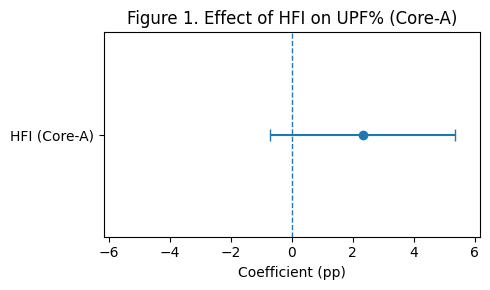

In [32]:
# ===== Figure 1: Core-A 的 HFI 系数（pp）— 简洁标题版 =====
est, ci, p = coef_ci(res_coreA, "HFI_binary")  # 取系数与CI
lo, hi = ci

fig, ax = plt.subplots(figsize=(5,3))
coefplot(
    ax,
    labels=["HFI (Core-A)"],
    est=est, lo=lo, hi=hi,
    title="Figure 1. Effect of HFI on UPF% (Core-A)",   # ← 无数值
    xlabel="Coefficient (pp)"
)

# 让 0 在中间：对称设置 x 轴范围
half = max(abs(lo), abs(hi)) * 1.15
ax.set_xlim(-half, half)

plt.tight_layout()
plt.show()


# 3. Core-B 交互（HFI × 族裔三类；参考White）

In [12]:
# # 输出：各族裔下HFI边际效应 + 交互整体检验p值
form_coreB = (
    f"{y} ~ HFI_binary"
    " + age_participant"
    " + C(gender_participant)"
    " + C(ethn_participant, Treatment(reference='White'))"
    " + child_numbers"
    " + HFI_binary:C(ethn_participant, Treatment(reference='White'))"
)

# 为避免样本不同导致的差异，这里用“交互模型所需完整样本”
need_cols_B = coreA_cols  # 交互不增加额外主效应列
dat_coreB = df_model[need_cols_B].dropna().copy()
print(f"\nCore-B 样本量: {len(dat_coreB)}")
res_coreB = fit_ols(form_coreB, dat_coreB, cov_type="HC3")

# 计算各族裔下 HFI 的边际效应
groups = ["White", "Asian", "All other ethnicities"]
effects = []
for g in groups:
    if g == "White":
        combo = {"HFI_binary":1.0}  # 参考组无交互项
    else:
        combo = {"HFI_binary":1.0, f"HFI_binary:C(ethn_participant, Treatment(reference='White'))[T.{g}]":1.0}
    e, ci_g, p_g = linear_combo(res_coreB, combo)
    effects.append((g, e, ci_g, p_g))
    print(f"{g}: ΔUPF = {e:.2f} pp (95%CI {ci_g[0]:.2f}, {ci_g[1]:.2f}), p={p_g:.3f}")

p_inter = joint_test_interaction(res_coreB, "HFI_binary:C(ethn_participant, Treatment(reference='White'))")
print(f"交互整体检验 p-value = {p_inter:.3f}")


Core-B 样本量: 304
White: ΔUPF = 0.99 pp (95%CI -3.23, 5.22), p=0.644
Asian: ΔUPF = 2.16 pp (95%CI -2.92, 7.25), p=0.404
All other ethnicities: ΔUPF = 7.48 pp (95%CI -0.94, 15.90), p=0.082
交互整体检验 p-value = 0.405


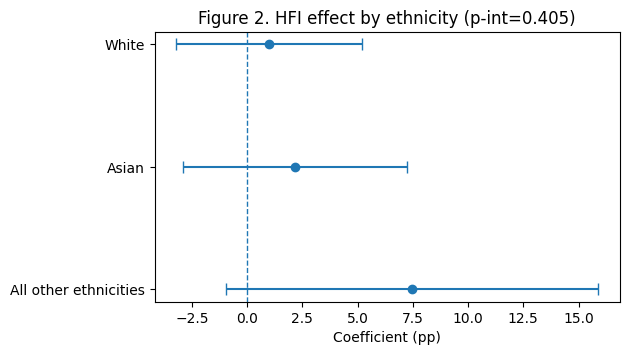

In [13]:
# Figure 2: 三族裔并列的边际效应图
fig2, ax2 = plt.subplots(figsize=(6,3.5))
labs = [g for g,_,_,_ in effects]
ests = [e for _,e,_,_ in effects]
los  = [ci[0] for _,_,ci,_ in effects]
his  = [ci[1] for _,_,ci,_ in effects]
coefplot(ax2, labs, ests, los, his, title=f"Figure 2. HFI effect by ethnicity (p-int={p_inter:.3f})")
plt.show()

# 4. Robustness（结构性混杂）：一次性加入 SES（income, employ）

In [14]:
# 报告：HFI 系数衰减百分比
# 同一样本比较 + 衰减百分比
# =========================================
ses_cols = coreA_cols + ["income", "employ"]
dat_R = df_model[ses_cols].dropna().copy()
print(f"\nRobustness(+SES) 样本量（统一样本）: {len(dat_R)}")

res_coreA_sameN = fit_ols(form_coreA, dat_R, cov_type="HC3")
res_ses         = fit_ols(form_coreA + " + income + C(employ)", dat_R, cov_type="HC3")

# --- 关键：用 get_term 取系数，兼容 ndarray/Series ---
b_core = get_term(res_coreA_sameN, "HFI_binary", np.nan)
b_ses  = get_term(res_ses,         "HFI_binary", np.nan)

ci_core_t = coef_ci(res_coreA_sameN, "HFI_binary")
ci_ses_t  = coef_ci(res_ses,         "HFI_binary")
ci_core = ci_core_t[1] if ci_core_t else (np.nan, np.nan)
ci_ses  = ci_ses_t[1]  if ci_ses_t  else (np.nan, np.nan)

atten = np.nan
if pd.notna(b_core) and not np.isclose(b_core, 0.0):
    atten = 100.0 * (b_core - b_ses) / abs(b_core)

print(f"HFI 系数：Core-A = {b_core:.2f} pp  →  +SES = {b_ses:.2f} pp；衰减 {atten:.1f}%")



Robustness(+SES) 样本量（统一样本）: 299
HFI 系数：Core-A = 2.75 pp  →  +SES = 3.34 pp；衰减 -21.3%


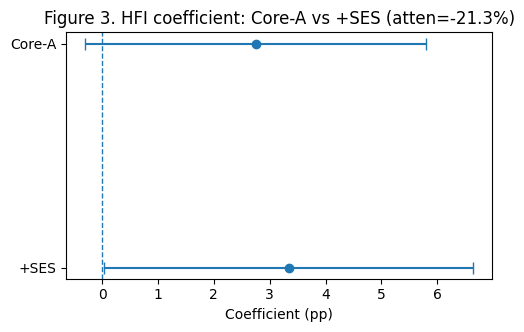

In [15]:
# ----- 绘图（Figure 3）-----
fig3, ax3 = plt.subplots(figsize=(5.5, 3.2))
coefplot(
    ax3,
    ["Core-A", "+SES"],
    [b_core, b_ses],
    [ci_core[0], ci_ses[0]],
    [ci_core[1], ci_ses[1]],
    title=f"Figure 3. HFI coefficient: Core-A vs +SES (atten={atten:.1f}%)"
)
plt.show()

# 5. Sensitivity（关键假设变化）

## 5.1 HFI 三分类(有序) + 趋势检验

In [16]:
# 期望已有列：HFI_category ∈ ["Food secure","Low food security","Very low food security"]
if "HFI_category" in df_model.columns:
    # 统一类型与顺序
    ord_dtype = pd.api.types.CategoricalDtype(
        categories=["Food secure","Low food security","Very low food security"], ordered=True
    )
    df_model["HFI_category"] = df_model["HFI_category"].astype(ord_dtype)

    sens_cols = coreA_cols + ["HFI_category"]
    dat_sens  = df_model[sens_cols].dropna().copy()
    print(f"\nSensitivity-有序三分类 样本量: {len(dat_sens)}")

    # (a) 类别模型（相对食品安全组）
    form_cat = (
        f"{y} ~ C(HFI_category, Treatment(reference='Food secure'))"
        " + age_participant + C(gender_participant)"
        " + C(ethn_participant, Treatment(reference='White'))"
        " + child_numbers"
    )
    res_cat = fit_ols(form_cat, dat_sens, cov_type="HC3")
    for lev in ["Low food security","Very low food security"]:
        term = f"C(HFI_category, Treatment(reference='Food secure'))[T.{lev}]"
        est, ci, p = coef_ci(res_cat, term)
        print(f"{lev}: {est:.2f} pp (95%CI {ci[0]:.2f}, {ci[1]:.2f}), p={p:.3f}")

    # (b) 趋势检验（0,1,2 连续）
    tr_map = {"Food secure":0, "Low food security":1, "Very low food security":2}
    dat_sens["HFI_trend"] = dat_sens["HFI_category"].map(tr_map).astype(float)
    form_trend = (
        f"{y} ~ HFI_trend"
        " + age_participant + C(gender_participant)"
        " + C(ethn_participant, Treatment(reference='White'))"
        " + child_numbers"
    )
    res_trend = fit_ols(form_trend, dat_sens, cov_type="HC3")
    est, ci, p = coef_ci(res_trend, "HFI_trend")
    print(f"p-trend: 每增加一档HFI，UPF% 变化 {est:.2f} pp (95%CI {ci[0]:.2f}, {ci[1]:.2f}), p={p:.3f}")
else:
    print("\n[跳过] 未找到 HFI_category（三分类）列，已跳过敏感性-三分类与趋势检验。")



Sensitivity-有序三分类 样本量: 304
Low food security: 0.87 pp (95%CI -3.11, 4.85), p=0.668
Very low food security: 3.80 pp (95%CI -0.06, 7.65), p=0.055
p-trend: 每增加一档HFI，UPF% 变化 1.75 pp (95%CI -0.11, 3.60), p=0.066


## 5.2 探索性交互：HFI × I(child_numbers≥3) （附录）

In [17]:
df_model["many_children"] = (df_model["child_numbers"] >= 3).astype("int")
cols_c3 = coreA_cols + ["many_children"]
dat_c3  = df_model[cols_c3].dropna().copy()
form_c3 = (
    f"{y} ~ HFI_binary + many_children + HFI_binary:many_children"
    " + age_participant + C(gender_participant)"
    " + C(ethn_participant, Treatment(reference='White'))"
    " + child_numbers"
)
res_c3 = fit_ols(form_c3, dat_c3, cov_type="HC3")
e, ci, p = coef_ci(res_c3, "HFI_binary:many_children")
print(f"[探索] HFI×(≥3个孩子) 交互 = {e:.2f} pp (95%CI {ci[0]:.2f}, {ci[1]:.2f}), p={p:.3f}")


[探索] HFI×(≥3个孩子) 交互 = 0.37 pp (95%CI -6.06, 6.79), p=0.911


## 5.3 族裔复核交互方向（附录）

In [18]:
# ============ 附录：族裔交互方向复核（仅三类） ============
# 目标：核对各组 HFI 边际效应方向 & 成对比较
# ============================================================

# ----- 保证与 Core-B 同样本 -----
need_cols_B = [y, "HFI_binary", "age_participant", "gender_participant",
               "ethn_participant", "child_numbers"]
dat_coreB = df_model[need_cols_B].dropna().copy()
print(f"[Appendix] 样本量（与Core-B一致）: {len(dat_coreB)}")

# ----- 重新拟合交互模型（参考组=White） -----
form_coreB = (
    f"{y} ~ HFI_binary"
    " + age_participant"
    " + C(gender_participant)"
    " + C(ethn_participant, Treatment(reference='White'))"
    " + child_numbers"
    " + HFI_binary:C(ethn_participant, Treatment(reference='White'))"
)
res_coreB = fit_ols(form_coreB, dat_coreB, cov_type="HC3")

# ----- 各组 HFI 边际效应（pp） -----
groups = ["White", "Asian", "All other ethnicities"]
appendix_eff = []
for g in groups:
    if g == "White":
        combo = {"HFI_binary": 1.0}
    else:
        combo = {
            "HFI_binary": 1.0,
            f"HFI_binary:C(ethn_participant, Treatment(reference='White'))[T.{g}]": 1.0
        }
    est_g, ci_g, p_g = linear_combo(res_coreB, combo)
    appendix_eff.append((g, est_g, ci_g[0], ci_g[1], p_g))

print("\n[各族裔组 HFI 边际效应]（pp）")
for g, e, lo, hi, p in appendix_eff:
    print(f"- {g:>22}: {e:.2f}  (95%CI {lo:.2f}, {hi:.2f}), p={p:.3f}")

# ----- 交互整体检验 -----
p_inter = joint_test_interaction(res_coreB, "HFI_binary:C(ethn_participant, Treatment(reference='White'))")
print(f"\n[交互整体检验] p-int = {p_inter:.3f}")

# ----- 成对比较：效应差（组A - 组B） -----
def pair_diff(result, A, B):
    """差值 = Effect_A - Effect_B"""
    # White 的效应是 b_HFI；其他组是在此基础上 + 各自交互项
    termA = f"HFI_binary:C(ethn_participant, Treatment(reference='White'))[T.{A}]"
    termB = f"HFI_binary:C(ethn_participant, Treatment(reference='White'))[T.{B}]"
    combo = {}
    if A != "White": combo[termA] = 1.0
    if B != "White": combo[termB] = -1.0
    # White 的主效应在差分中抵消，无需显式加入 HFI_binary
    # （若 A/B 含 White，则只保留另一个组的交互项）
    return linear_combo(result, combo if combo else {"HFI_binary":0.0})

pairs = [("Asian","White"), ("All other ethnicities","White"), ("Asian","All other ethnicities")]
pair_rows = []
print("\n[成对比较：效应差（组A - 组B）]  单位：pp")
for A,B in pairs:
    est_d, ci_d, p_d = pair_diff(res_coreB, A, B)
    print(f"- {A:>22}  -  {B:<22}:  {est_d:.2f}  (95%CI {ci_d[0]:.2f}, {ci_d[1]:.2f}), p={p_d:.3f}")
    pair_rows.append((A, B, est_d, ci_d[0], ci_d[1], p_d))

[Appendix] 样本量（与Core-B一致）: 304

[各族裔组 HFI 边际效应]（pp）
-                  White: 0.99  (95%CI -3.23, 5.22), p=0.644
-                  Asian: 2.16  (95%CI -2.92, 7.25), p=0.404
-  All other ethnicities: 7.48  (95%CI -0.94, 15.90), p=0.082

[交互整体检验] p-int = 0.405

[成对比较：效应差（组A - 组B）]  单位：pp
-                  Asian  -  White                 :  1.17  (95%CI -5.33, 7.67), p=0.725
-  All other ethnicities  -  White                 :  6.49  (95%CI -2.96, 15.94), p=0.178
-                  Asian  -  All other ethnicities :  -5.32  (95%CI -15.22, 4.58), p=0.292


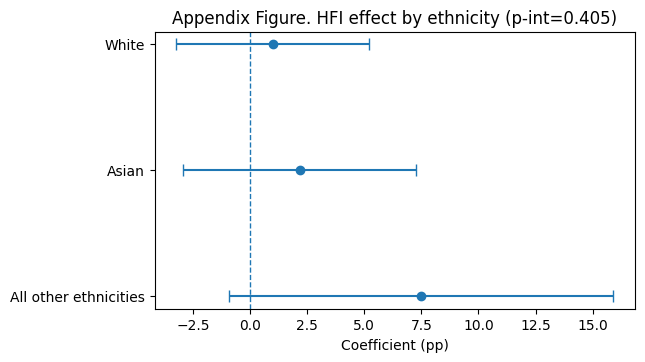

In [19]:
# ----- 附录图：三组边际效应并列 -----
labs_e = [r[0] for r in appendix_eff]
ests_e = [r[1] for r in appendix_eff]
los_e  = [r[2] for r in appendix_eff]
his_e  = [r[3] for r in appendix_eff]

figA, axA = plt.subplots(figsize=(6.2, 3.6))
coefplot(axA, labs_e, ests_e, los_e, his_e,
         title=f"Appendix Figure. HFI effect by ethnicity (p-int={p_inter:.3f})")
plt.show()

## 5.4 年龄每 +1SD 的效应

In [20]:
# =====================================================
# ========== Sensitivity：年龄每 +1SD 的效应 ==========
# （与 Core-A 同样本；系数即“每 +1SD 年龄，UPF% 的变化（pp）”）
# =====================================================
dat_ageSD = dat_coreA.copy()  # 保持与 Core-A 同样本
sd_age    = dat_ageSD["age_participant"].std()
dat_ageSD["z_age"] = (dat_ageSD["age_participant"] - dat_ageSD["age_participant"].mean()) / sd_age

form_ageSD = (
    f"{y} ~ HFI_binary + z_age + C(gender_participant)"
    " + C(ethn_participant, Treatment(reference='White')) + child_numbers"
)
res_ageSD = fit_ols(form_ageSD, dat_ageSD, cov_type="HC3")
age_sd_est, age_sd_ci, age_sd_p = coef_ci(res_ageSD, "z_age")

print(
    f"年龄每 +1SD（SD={sd_age:.2f} 岁）UPF% 变化 = {age_sd_est:.2f} pp "
    f"(95%CI {age_sd_ci[0]:.2f}, {age_sd_ci[1]:.2f}), p={age_sd_p:.3f}; N={len(dat_ageSD)}"
)


年龄每 +1SD（SD=2.59 岁）UPF% 变化 = 1.28 pp (95%CI -0.04, 2.61), p=0.059; N=304


# 6. Table 1（描述性摘要）

In [21]:
def table1(df):
    out = {}
    # 年龄
    out["Age (years), mean ± SD"] = f"{df['age_participant'].mean():.2f} ± {df['age_participant'].std():.2f}"
    # 性别分布
    gdist = df["gender_participant"].value_counts(dropna=False, normalize=True).rename(lambda x: f"Gender: {x}")
    for k, v in gdist.items():
        out[k] = f"{v*100:.1f}%"
    # 族裔三类分布
    edist = df["ethn_participant"].value_counts(dropna=False, normalize=True)
    for k, v in edist.items():
        label = "Missing" if pd.isna(k) else k
        out[f"Ethnicity ({label})"] = f"{v*100:.1f}%"
    # HFI 流行率
    if "HFI_binary" in df.columns:
        hfi_prev = df["HFI_binary"].mean()*100
        out["HFI prevalence"] = f"{hfi_prev:.1f}%"
    # 各族裔UPF原始均值（简版）
    m = df.groupby("ethn_participant")[y].mean().round(2)
    for k, v in m.items():
        out[f"UPF% mean - {k}"] = f"{v:.2f}"
    # 汇总为一列表
    return pd.DataFrame({"Value": pd.Series(out)})

t1_df = table1(df_model[coreA_cols])
print("\nTable 1（主样本，含三类族裔）:")
display(t1_df)


Table 1（主样本，含三类族裔）:


/tmp/ipython-input-1411111733.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  m = df.groupby("ethn_participant")[y].mean().round(2)


,Value
"Age (years), mean ± SD",6.90 ± 2.59
Gender: 1,51.0%
Gender: 2,49.0%
Ethnicity (White),54.9%
Ethnicity (Asian),32.5%
Ethnicity (All other ethnicities),12.7%
HFI prevalence,31.5%
UPF% mean - White,71.80
UPF% mean - Asian,66.12
UPF% mean - All other ethnicities,67.55


# 可视化

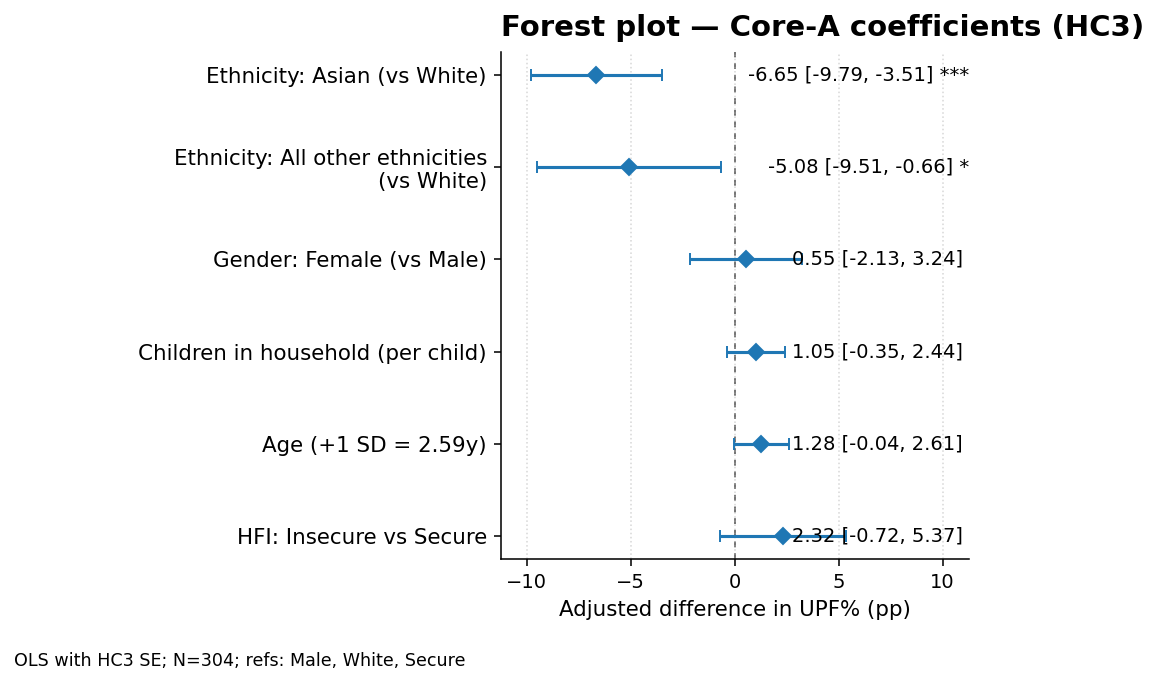

<Figure size 640x480 with 0 Axes>

In [28]:
# =========================================================
# ============ 美化版 Forest Plot — Core-A (HC3) ==========
# =========================================================
import re, textwrap
import numpy as np
import matplotlib.pyplot as plt

show_age_per_sd = True     # ← 若想显示“每 +1SD”，置 True；否则按每年
gender_map = {1:"Male", 2:"Female", 3:"Other"}  # 你给定的性别口径

# ---------- 1) 取系数并（可选）把年龄换算为 +1SD ----------
names, params, bse, pvals = _names_params_bse_p(res_coreA)
z = _zcrit(0.05)
ci_lo = params - z*bse
ci_hi = params + z*bse
df = pd.DataFrame({
    "term": names, "b": params.values, "se": bse.values,
    "lo": ci_lo.values, "hi": ci_hi.values, "p": pvals.values
})

# 仅保留关心的项
keep = (
    (df.term=="HFI_binary") |
    (df.term=="age_participant") |
    (df.term=="child_numbers") |
    (df.term.str.startswith("C(gender_participant")) |
    (df.term.str.startswith("C(ethn_participant"))
)
df = df.loc[keep].copy()

# 年龄换算为 +1SD
if show_age_per_sd and "age_participant" in df.term.values:
    sd_age = dat_coreA["age_participant"].std()
    idx = df.term=="age_participant"
    df.loc[idx, ["b","lo","hi","se"]] = df.loc[idx, ["b","lo","hi","se"]].values * sd_age
    age_label = f"Age (+1 SD = {sd_age:.2f}y)"
else:
    age_label = "Age (per year)"

# ---------- 2) 生成可读标签 ----------
def nice_label(term: str) -> str:
    if term=="HFI_binary": return "HFI: Insecure vs Secure"
    if term=="age_participant": return age_label
    if term=="child_numbers": return "Children in household (per child)"
    mg = re.match(r"C\(gender_participant.*\)\[T\.(.+)\]", term)
    if mg:
        v = mg.group(1).strip()
        try: v = gender_map.get(int(v), str(v))
        except: v = gender_map.get(v, v)
        return f"Gender: {v} (vs Male)"
    me = re.match(r"C\(ethn_participant.*\)\[T\.(.+)\]", term)
    if me:
        v = me.group(1).strip()
        return f"Ethnicity: {v} (vs White)"
    return term

df["label"] = df["term"].apply(nice_label)
df["label_wrapped"] = df["label"].apply(lambda s: textwrap.fill(s, width=34))

# 排序：HFI → Age → Children → Gender → Ethnicity
order = ["HFI_binary","age_participant","child_numbers"]
order += sorted(df.loc[df.term.str.startswith("C(gender_participant"),"term"])
order += sorted(df.loc[df.term.str.startswith("C(ethn_participant"),"term"])
df = df.set_index("term").loc[order].reset_index()

# ---------- 3) 绘图 ----------
labels = df["label_wrapped"].tolist()
b, lo, hi, p = df["b"].to_numpy(), df["lo"].to_numpy(), df["hi"].to_numpy(), df["p"].to_numpy()
y = np.arange(len(labels))

def pstars(pv): return "***" if pv<0.001 else "**" if pv<0.01 else "*" if pv<0.05 else ""

fig, ax = plt.subplots(figsize=(8.2, 5.2), dpi=140)

# 美化：网格、0线、去除上右脊
ax.grid(axis="x", linestyle=":", linewidth=0.8, alpha=0.5, zorder=0)
ax.axvline(0, linestyle=(0,(3,3)), linewidth=1, color="0.45", zorder=1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# 误差线 + 菱形点（更醒目）
xerr = np.vstack([b-lo, hi-b])
ax.errorbar(b, y, xerr=xerr, fmt="D", ms=6, lw=1.6, capsize=3, zorder=2)

# 轴与标题
ax.set_yticks(y); ax.set_yticklabels(labels, fontsize=11)
ax.set_xlabel("Adjusted difference in UPF% (pp)", fontsize=11)
ax.set_title("Forest plot — Core-A coefficients (HC3)", loc="left", fontsize=15, weight="bold", pad=8)

# 对称坐标范围
pad = 1.15 * max(abs(lo.min()), abs(hi.max()))
ax.set_xlim(-pad, pad)

# 右侧数值 + 星号
xr = ax.get_xlim()[1]
for yi, (bi, loi, hii, pi) in enumerate(zip(b, lo, hi, p)):
    ax.text(xr, yi, f"{bi:.2f} [{loi:.2f}, {hii:.2f}] {pstars(pi)}",
            ha="right", va="center", fontsize=10)

# 页脚注释
fig.text(0.13, 0.02, f"OLS with HC3 SE; N={len(dat_coreA)}; refs: Male, White, Secure",
         ha="left", va="bottom", fontsize=9)
plt.tight_layout(rect=[0.22, 0.06, 0.98, 0.95])
plt.show()

# （可选）保存为高清图
plt.savefig("/content/drive/MyDrive/UPF-HFI/Model/output/forest_coreA.png", dpi=300, bbox_inches="tight")


/tmp/ipython-input-1579071975.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = dat_hfi3.groupby("HFI_category")[y]


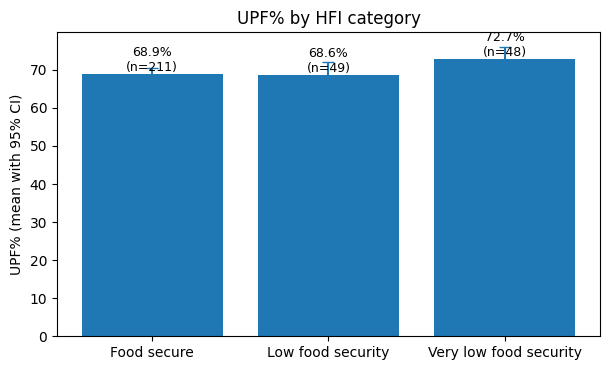

In [33]:
# ==============================================
# ===== Figure S1. UPF% means by HFI category ===
# ==============================================
from pandas.api.types import CategoricalDtype

y = "weighted_upf_percent"

if "HFI_category" in df_model.columns:
    ord_dtype = CategoricalDtype(
        categories=["Food secure","Low food security","Very low food security"], ordered=True
    )
    df_model["HFI_category"] = df_model["HFI_category"].astype(ord_dtype)

    dat_hfi3 = df_model[[y, "HFI_category"]].dropna().copy()
    g = dat_hfi3.groupby("HFI_category")[y]
    stats = g.agg(mean="mean", sd="std", n="size").reset_index()
    stats["se"]    = stats["sd"] / np.sqrt(stats["n"])
    stats["ci_lo"] = stats["mean"] - _zcrit(0.05) * stats["se"]
    stats["ci_hi"] = stats["mean"] + _zcrit(0.05) * stats["se"]

    fig, ax = plt.subplots(figsize=(6.2,3.8))
    xpos = np.arange(len(stats))
    ax.bar(xpos, stats["mean"].values)
    yerr = np.vstack([stats["mean"].values - stats["ci_lo"].values,
                      stats["ci_hi"].values - stats["mean"].values])
    ax.errorbar(xpos, stats["mean"].values, yerr=yerr, fmt='none', capsize=4)
    for i,(m,n) in enumerate(zip(stats["mean"].values, stats["n"].values)):
        ax.text(i, m, f"{m:.1f}%\n(n={n})", ha="center", va="bottom", fontsize=9)
    ax.set_xticks(xpos)
    ax.set_xticklabels(stats["HFI_category"].astype(str), rotation=0)
    ax.set_ylabel("UPF% (mean with 95% CI)")
    ax.set_title("UPF% by HFI category")
    plt.tight_layout()
    plt.show()
else:
    print("[跳过] 未找到 HFI_category（三分类）列。")


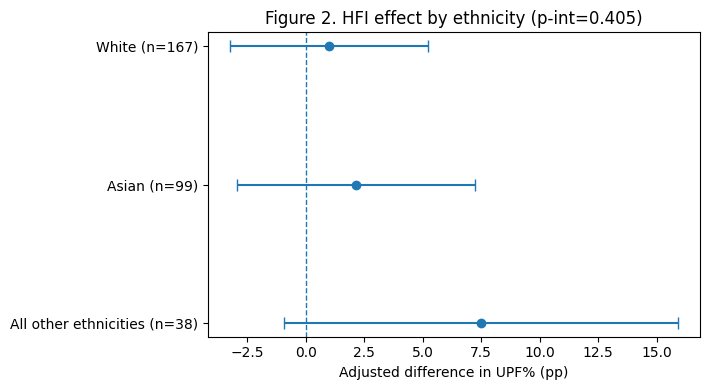

In [34]:
# =========================================================
# ===== Figure 2 (refined). HFI effect by ethnicity (n) ===
# =========================================================
# 需要你之前已经跑过 Core-B 并得到 effects, p_inter, dat_coreB
# effects: [(group, est, (lo, hi), p), ...]  groups = ["White","Asian","All other ethnicities"]

counts = dat_coreB["ethn_participant"].value_counts()
labs_n = []
ests, los, his = [], [], []
for (g, e, ci, p) in effects:
    n_g = int(counts.get(g, 0))
    labs_n.append(f"{g} (n={n_g})")
    ests.append(e); los.append(ci[0]); his.append(ci[1])

fig2b, ax2b = plt.subplots(figsize=(7.2, 4.0))
coefplot(ax2b, labs_n, ests, los, his,
         title=f"Figure 2. HFI effect by ethnicity (p-int={p_inter:.3f})",
         xlabel="Adjusted difference in UPF% (pp)")
# 0 线已经在 coefplot 内 ax.axvline(0,'--',1)
plt.tight_layout()
plt.show()


/tmp/ipython-input-1596099520.py:26: UserWarning: Glyph 65291 (\N{FULLWIDTH PLUS SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65291 (\N{FULLWIDTH PLUS SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


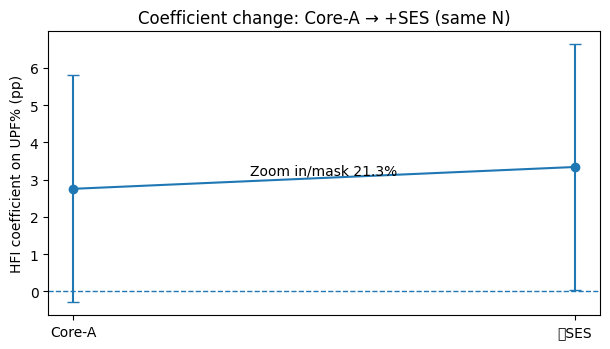

In [36]:
# ======================================================
# ===== Figure 3b. Coefficient change Core-A → +SES ====
# ======================================================
# 需要你之前已得到：b_core, b_ses, ci_core, ci_ses, dat_R
delta_pct = 100.0 * (b_ses - b_core) / (abs(b_core) if b_core!=0 else np.nan)  # 相对变化
atten_pct = 100.0 * (b_core - b_ses) / (abs(b_core) if b_core!=0 else np.nan)  # 你原来的“衰减”定义
label_txt = (f"attenuation {atten_pct:.1f}%" # 衰减
             if np.sign(b_core)==np.sign(b_ses) and abs(b_ses) < abs(b_core)
             else f"Zoom in/mask {abs(delta_pct):.1f}%") # 放大/遮蔽

xs = np.array([0,1]); names = ["Core-A","＋SES"]
ys = np.array([b_core, b_ses])
yerr = np.vstack([[ys[0]-ci_core[0], ys[1]-ci_ses[0]],
                  [ci_core[1]-ys[0], ci_ses[1]-ys[1]]])

fig4, ax4 = plt.subplots(figsize=(6.2, 3.6))
ax4.plot(xs, ys, marker='o')
ax4.errorbar(xs, ys, yerr=yerr, fmt='none', capsize=4)
ax4.axhline(0, linestyle='--', linewidth=1)
ax4.set_xticks(xs); ax4.set_xticklabels(names)
ax4.set_ylabel("HFI coefficient on UPF% (pp)")
ax4.set_title("Coefficient change: Core-A → +SES (same N)")
# 在两点中间位置标注变化
x_mid = 0.5; y_mid = (ys[0]+ys[1])/2
ax4.text(x_mid, y_mid, label_txt, ha="center", va="bottom")
plt.tight_layout()
plt.show()


In [37]:
# ======================================================
# ===== Table S2. UPF% median (IQR) by HFI grouping ====
# ======================================================
def median_iqr(s):
    q1, q2, q3 = s.quantile([0.25, 0.5, 0.75])
    return pd.Series({"median": q2, "IQR": q3-q1})

# 二分类
t2 = df_model[[y,"HFI_binary"]].dropna().groupby("HFI_binary")[y].apply(median_iqr)
print("UPF% median (IQR) by HFI_binary:")
display(t2)

# 三分类（若有）
if "HFI_category" in df_model.columns:
    t3 = df_model[[y,"HFI_category"]].dropna().groupby("HFI_category")[y].apply(median_iqr)
    print("UPF% median (IQR) by HFI_category:")
    display(t3)


UPF% median (IQR) by HFI_binary:


HFI_binary        
0.0         median    69.843906
            IQR       15.555596
1.0         median    71.512692
            IQR       15.858650
Name: weighted_upf_percent, dtype: float64

UPF% median (IQR) by HFI_category:


/tmp/ipython-input-2324727808.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t3 = df_model[[y,"HFI_category"]].dropna().groupby("HFI_category")[y].apply(median_iqr)


HFI_category                  
Food secure             median    69.843906
                        IQR       15.555596
Low food security       median    70.341385
                        IQR       16.555222
Very low food security  median    74.802479
                        IQR       14.520846
Name: weighted_upf_percent, dtype: float64

In [38]:
# ==============================================
# ===== Table S1. HFI prevalence by ethnicity ===
# ==============================================
tab_ethn_hfi = (pd.crosstab(df_model["ethn_participant"], df_model["HFI_binary"])
                .assign(total=lambda d: d.sum(axis=1)))
tab_ethn_hfi_pct = (tab_ethn_hfi.div(tab_ethn_hfi["total"], axis=0).drop(columns="total")*100).round(1)
print("HFI prevalence within each ethnicity (%):")
display(tab_ethn_hfi_pct)


HFI prevalence within each ethnicity (%):


HFI_binary,0.0,1.0
ethn_participant,,
White,75.7,24.3
Asian,58.0,42.0
All other ethnicities,64.1,35.9


In [39]:
# ===================================================
# ===== Table S3. USDA 6-item item-level rates  =====
# ===================================================
cand_cols = [c for c in df_model.columns
             if any(k in c.lower() for k in ["hfi","usda","hfssm","food_insec"])
             and df_model[c].dropna().isin([0,1]).all()]

if cand_cols:
    item_rates = (df_model[cand_cols].mean()*100).round(1).sort_values(ascending=False)
    item_df = pd.DataFrame({"item": item_rates.index, "positive_%": item_rates.values})
    print("Item-level positive rates (%):")
    display(item_df)
else:
    print("[提示] 未自动识别到 USDA 6-item 的题目列（0/1）。如需报表，请指定列名列表。")


Item-level positive rates (%):


,item,positive_%
0,HFI_binary,31.5


/tmp/ipython-input-2226645711.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = dat_hfi3.groupby("HFI_category")[y]


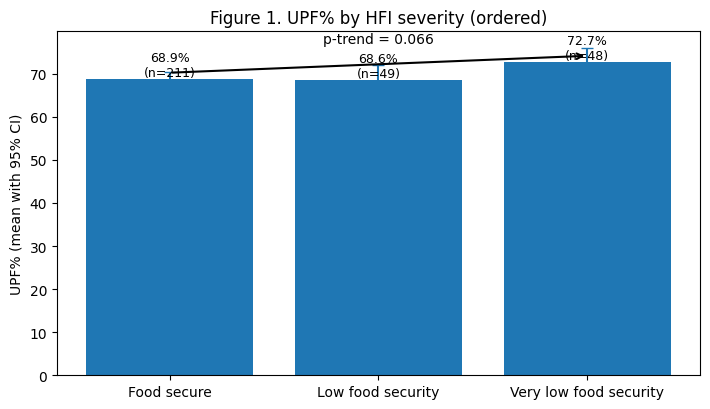

In [41]:
# ==========================================================
# ===== Figure 1 (fixed). UPF% by HFI ordered level ========
# ==========================================================
from pandas.api.types import CategoricalDtype

y = "weighted_upf_percent"
assert y in df_model.columns, "未找到 weighted_upf_percent"

# --- 三分类有序因子 ---
ord_dtype = CategoricalDtype(
    categories=["Food secure","Low food security","Very low food security"],
    ordered=True
)
df_model["HFI_category"] = df_model["HFI_category"].astype(ord_dtype)

# --- 组别均值与95%CI（画柱子用原始均值） ---
dat_hfi3 = df_model[[y, "HFI_category"]].dropna().copy()
g = dat_hfi3.groupby("HFI_category")[y]
stats = g.agg(mean="mean", sd="std", n="size").reset_index()
stats["se"]    = stats["sd"] / np.sqrt(stats["n"])
stats["ci_lo"] = stats["mean"] - _zcrit(0.05) * stats["se"]
stats["ci_hi"] = stats["mean"] + _zcrit(0.05) * stats["se"]

# --- p-trend：把三分类映射为 0/1/2，并与 Core-A 同协变量一起拟合 ---
trend_map = {"Food secure":0, "Low food security":1, "Very low food security":2}
need_cols = [y, "HFI_category", "age_participant", "gender_participant",
             "ethn_participant", "child_numbers"]
dat_tr = df_model[need_cols].dropna().copy()
dat_tr["HFI_trend"] = dat_tr["HFI_category"].map(trend_map).astype(float)

form_trend = (
    f"{y} ~ HFI_trend"
    " + age_participant + C(gender_participant)"
    " + C(ethn_participant, Treatment(reference='White'))"
    " + child_numbers"
)
res_trend = fit_ols(form_trend, dat_tr)
trend_coef = coef_ci(res_trend, "HFI_trend")
p_trend = trend_coef[2] if trend_coef else np.nan

# --- 绘图 ---
fig, ax = plt.subplots(figsize=(7.2, 4.2))
xpos = np.arange(len(stats))
ax.bar(xpos, stats["mean"].values)

yerr = np.vstack([stats["mean"] - stats["ci_lo"], stats["ci_hi"] - stats["mean"]])
ax.errorbar(xpos, stats["mean"], yerr=yerr, fmt='none', capsize=4)

for i,(m,n) in enumerate(zip(stats["mean"], stats["n"])):
    ax.text(i, m, f"{m:.1f}%\n(n={n})", ha="center", va="bottom", fontsize=9)

ax.set_xticks(xpos)
ax.set_xticklabels(stats["HFI_category"].astype(str))
ax.set_ylabel("UPF% (mean with 95% CI)")
ax.set_title("Figure 1. UPF% by HFI severity (ordered)")

# 趋势箭头 + p-trend
x0, y0 = xpos[0], stats["mean"].iloc[0]
x1, y1 = xpos[-1], stats["mean"].iloc[-1]
ax.annotate("", xy=(x1, y1*1.02), xytext=(x0, y0*1.02),
            arrowprops=dict(arrowstyle="->", lw=1.5))
ax.text((x0+x1)/2, max(y0,y1)*1.05,
        f"p-trend = {p_trend:.3f}", ha="center", va="bottom", fontsize=10)

plt.tight_layout(); plt.show()


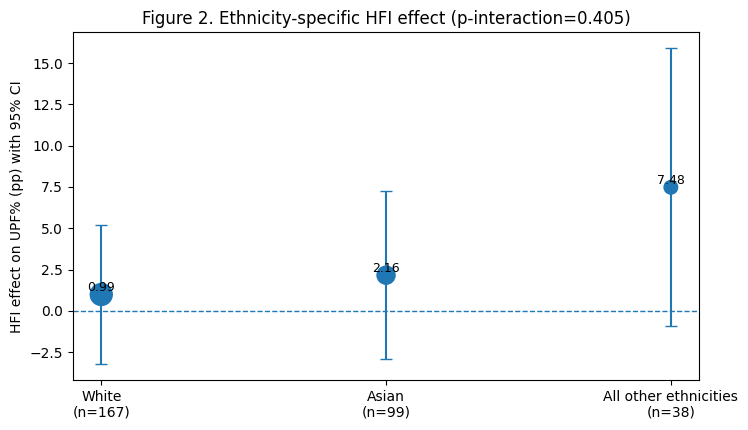

In [42]:
# =====================================================================
# ===== Figure 2 (upgraded). Ethnicity-specific effect, bubble size ====
# =====================================================================
# 若 effects/p_inter/dat_coreB 尚未存在，则现场计算一次
try:
    _ = effects, p_inter, dat_coreB
except NameError:
    # 与 Core-B 同样本
    need_cols_B = [y,"HFI_binary","age_participant","gender_participant","ethn_participant","child_numbers"]
    dat_coreB = df_model[need_cols_B].dropna().copy()
    form_coreB = (
        f"{y} ~ HFI_binary + age_participant + C(gender_participant)"
        " + C(ethn_participant, Treatment(reference='White')) + child_numbers"
        " + HFI_binary:C(ethn_participant, Treatment(reference='White'))"
    )
    res_coreB = fit_ols(form_coreB, dat_coreB)
    groups = ["White","Asian","All other ethnicities"]
    effects = []
    for g in groups:
        if g=="White":
            combo={"HFI_binary":1.0}
        else:
            combo={"HFI_binary":1.0,
                   f"HFI_binary:C(ethn_participant, Treatment(reference='White'))[T.{g}]":1.0}
        e, ci, p = linear_combo(res_coreB, combo)
        effects.append((g, e, ci, p))
    p_inter = joint_test_interaction(res_coreB, "HFI_binary:C(ethn_participant, Treatment(reference='White'))")

# 组样本量
counts = dat_coreB["ethn_participant"].value_counts()
x_labels = [e[0] for e in effects]
x = np.arange(len(x_labels))
y_eff = np.array([e[1] for e in effects])
ci_lo = np.array([e[2][0] for e in effects])
ci_hi = np.array([e[2][1] for e in effects])
ns = np.array([int(counts.get(lbl,0)) for lbl in x_labels])

# 气泡大小（面积 ~ n），做个温和的缩放
s = (200 * (ns / ns.max()))**1.0 + 50

fig, ax = plt.subplots(figsize=(7.6, 4.4))
# 误差线
ax.errorbar(x, y_eff, yerr=np.vstack([y_eff-ci_lo, ci_hi-y_eff]), fmt='none', capsize=4)
# 气泡
ax.scatter(x, y_eff, s=s)

# 基线 0
ax.axhline(0, linestyle='--', linewidth=1)

# 轴 & 标签
ax.set_xticks(x)
ax.set_xticklabels([f"{lbl}\n(n={n})" for lbl,n in zip(x_labels, ns)])
ax.set_ylabel("HFI effect on UPF% (pp) with 95% CI")
ax.set_title(f"Figure 2. Ethnicity-specific HFI effect (p-interaction={p_inter:.3f})")

# 在每个点上标注数值
for xi, yi in zip(x, y_eff):
    ax.text(xi, yi, f"{yi:.2f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


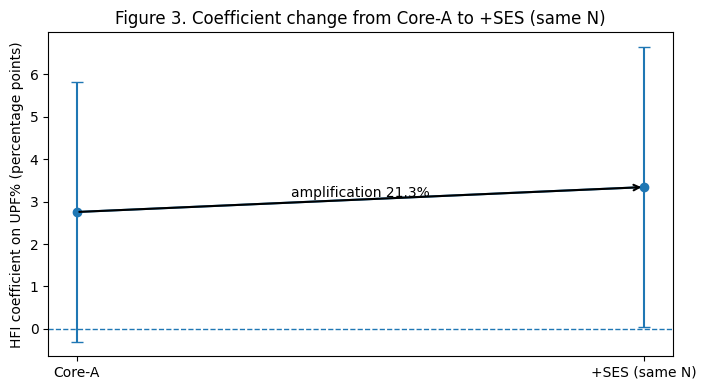

In [45]:
# =================================================================
# ===== Figure 3 (upgraded). Coefficient path: Core-A → +SES  =====
# =================================================================
# Plots the HFI coefficient from Core-A and the +SES model (same N),
# draws an arrow between them, and annotates the % change.
# If b_core/b_ses/etc. are not defined yet, we compute them here.

try:
    _ = b_core, b_ses, ci_core, ci_ses, dat_R
except NameError:
    ses_cols = [
        "weighted_upf_percent", "HFI_binary",
        "age_participant", "gender_participant",
        "ethn_participant", "child_numbers",
        "income", "employ"
    ]
    dat_R = df_model[ses_cols].dropna().copy()

    form_coreA = (
        "weighted_upf_percent ~ HFI_binary"
        " + age_participant"
        " + C(gender_participant)"
        " + C(ethn_participant, Treatment(reference='White'))"
        " + child_numbers"
    )
    res_coreA_sameN = fit_ols(form_coreA, dat_R)
    res_ses = fit_ols(form_coreA + " + income + C(employ)", dat_R)

    b_core = get_term(res_coreA_sameN, "HFI_binary")
    b_ses  = get_term(res_ses,         "HFI_binary")

    ci_core = coef_ci(res_coreA_sameN, "HFI_binary")[1]
    ci_ses  = coef_ci(res_ses,         "HFI_binary")[1]

# % attenuation (your baseline definition); label chooses attenuation vs amplification
if b_core != 0 and pd.notna(b_core) and pd.notna(b_ses):
    atten = 100.0 * (b_core - b_ses) / abs(b_core)
else:
    atten = np.nan

label_txt = (
    f"attenuation {atten:.1f}%"
    if (pd.notna(atten) and abs(b_ses) < abs(b_core) and np.sign(b_ses)==np.sign(b_core))
    else f"amplification {abs(100.0*(b_ses-b_core)/(abs(b_core) if b_core!=0 else np.nan)):.1f}%"
)

# ---- Plot ----
fig, ax = plt.subplots(figsize=(7.2, 4.0))
xs = np.array([0, 1])
ys = np.array([b_core, b_ses])
names = ["Core-A", "+SES (same N)"]

# points and 95% CIs
ax.plot(xs, ys, marker='o')
yerr = np.vstack([
    [ys[0]-ci_core[0], ys[1]-ci_ses[0]],
    [ci_core[1]-ys[0], ci_ses[1]-ys[1]]
])
ax.errorbar(xs, ys, yerr=yerr, fmt='none', capsize=4)

# zero line
ax.axhline(0, linestyle='--', linewidth=1)

# arrow + annotation
ax.annotate("", xy=(1, ys[1]), xytext=(0, ys[0]),
            arrowprops=dict(arrowstyle="->", lw=1.5))
x_mid = 0.5
y_mid = (ys[0] + ys[1]) / 2
ax.text(x_mid, y_mid, label_txt, ha="center", va="bottom", fontsize=10)

ax.set_xticks(xs); ax.set_xticklabels(names)
ax.set_ylabel("HFI coefficient on UPF% (percentage points)")
ax.set_title("Figure 3. Coefficient change from Core-A to +SES (same N)")
plt.tight_layout(); plt.show()
